In [12]:
#Paso 2. Preparar los datos para el análisis

import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos con el separador correcto
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

# Renombrar columnas para facilitar el trabajo
df.columns = ['event_name', 'user_id', 'timestamp', 'exp_id']

# Comprobar tipos de datos y valores faltantes
print("Tipos de datos:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isnull().sum())

# Convertir timestamp a datetime (fecha y hora completa)
df['event_datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Crear columna solo con la fecha (sin hora)
df['event_date'] = df['event_datetime'].dt.date

# Mostrar una vista previa de los datos procesados
print("\nDatos procesados:\n")
print(df.head())

# Comprobación final
print("\nTipos de datos después de la conversión:\n", df.dtypes)





Tipos de datos:
 event_name    object
user_id        int64
timestamp      int64
exp_id         int64
dtype: object

Valores nulos por columna:
 event_name    0
user_id       0
timestamp     0
exp_id        0
dtype: int64

Datos procesados:

                event_name              user_id   timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257  1564029816     246   
1         MainScreenAppear  7416695313311560658  1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509  1564054127     248   
3         CartScreenAppear  3518123091307005509  1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999  1564055322     248   

       event_datetime  event_date  
0 2019-07-25 04:43:36  2019-07-25  
1 2019-07-25 11:11:42  2019-07-25  
2 2019-07-25 11:28:47  2019-07-25  
3 2019-07-25 11:28:47  2019-07-25  
4 2019-07-25 11:48:42  2019-07-25  

Tipos de datos después de la conversión:
 event_name                object
user_id                    int64
timesta

Total de eventos: 244126
Total de usuarios únicos: 7551
Promedio de eventos por usuario: 32.33
Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


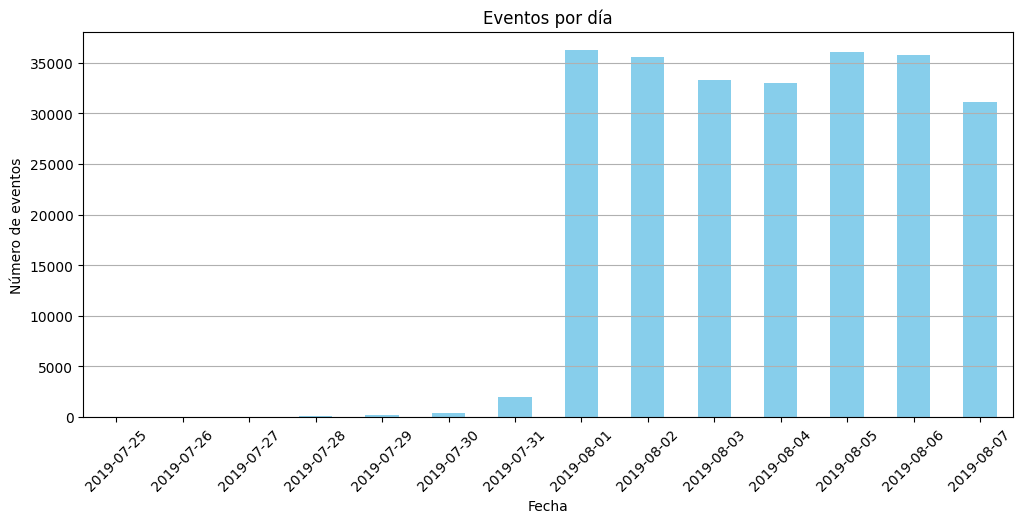

In [13]:
#Paso 3. Estudiar y comprobar los datos

#¿Cuántos eventos hay en los registros?
total_eventos = df.shape[0]
print("Total de eventos:", total_eventos)

#¿Cuántos usuarios hay en los registros?
total_usuarios = df['user_id'].nunique()
print("Total de usuarios únicos:", total_usuarios)

#¿Cuál es el promedio de eventos por usuario?
promedio_eventos = total_eventos / total_usuarios
print("Promedio de eventos por usuario:", round(promedio_eventos, 2))

#Periodo de tiempo cubierto por los datos:
fecha_min = df['event_datetime'].min()
fecha_max = df['event_datetime'].max()

print("Fecha mínima:", fecha_min)
print("Fecha máxima:", fecha_max)

import matplotlib.pyplot as plt

# Agrupar eventos por día
eventos_por_dia = df.groupby(df['event_date']).size()

# Graficar
plt.figure(figsize=(12,5))
eventos_por_dia.plot(kind='bar', color='skyblue')
plt.title("Eventos por día")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()





In [14]:

# ¿Se perdieron muchos eventos y usuarios al excluir los datos antiguos?

# Eventos y usuarios antes del filtrado
eventos_antes = df.shape[0]
usuarios_antes = df['user_id'].nunique()

# Eventos y usuarios después del filtrado
eventos_despues = df_filtrado.shape[0]
usuarios_despues = df_filtrado['user_id'].nunique()

# Pérdidas
eventos_perdidos = eventos_antes - eventos_despues
usuarios_perdidos = usuarios_antes - usuarios_despues

print(f"Eventos perdidos al filtrar: {eventos_perdidos} ({round(eventos_perdidos/eventos_antes*100,2)}%)")
print(f"Usuarios perdidos al filtrar: {usuarios_perdidos} ({round(usuarios_perdidos/usuarios_antes*100,2)}%)")

# -----------------------------
# Asegúrate de tener usuarios de los tres grupos experimentales
# -----------------------------

print("Usuarios por grupo experimental en los datos filtrados:")
print(df_filtrado['exp_id'].value_counts())


Eventos perdidos al filtrar: 2828 (1.16%)
Usuarios perdidos al filtrar: 17 (0.23%)
Usuarios por grupo experimental en los datos filtrados:
248    84726
246    79425
247    77147
Name: exp_id, dtype: int64


In [15]:
#Paso 4. Estudiar el embudo de eventos

# Contar la frecuencia de cada evento en los datos filtrados
eventos_frecuencia = df_filtrado['event_name'].value_counts()

# Mostrar resultados
print("Eventos y su frecuencia:\n")
print(eventos_frecuencia)

Eventos y su frecuencia:

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64


In [16]:
# Total de usuarios únicos en el periodo filtrado
total_usuarios = df_filtrado['user_id'].nunique()

# Calcular usuarios únicos por evento
usuarios_por_evento = df_filtrado.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

# Calcular proporción de usuarios por evento
proporcion_usuarios = usuarios_por_evento / total_usuarios

# Mostrar resultados
print("Cantidad de usuarios únicos por evento:\n")
print(usuarios_por_evento)

print("\nProporción de usuarios por evento:\n")
print(proporcion_usuarios.round(3))


Cantidad de usuarios únicos por evento:

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Proporción de usuarios por evento:

event_name
MainScreenAppear           0.985
OffersScreenAppear         0.610
CartScreenAppear           0.496
PaymentScreenSuccessful    0.470
Tutorial                   0.111
Name: user_id, dtype: float64


**¿En qué orden crees que ocurrieron las acciones? 
¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.**

Basado en los eventos observados, el flujo lógico de la aplicación es:

MainScreenAppear – Pantalla principal (inicio de sesión o apertura de la app)

OffersScreenAppear – Usuario ve las ofertas

CartScreenAppear – Usuario agrega algo al carrito

PaymentScreenSuccessful – Usuario realiza la compra con éxito

Tutorial – Evento independiente (no forma parte de la secuencia principal)

In [17]:
# Cantidad de usuarios por evento relevante
usuarios_eventos = {
    'MainScreenAppear': 7419,
    'OffersScreenAppear': 4593,
    'CartScreenAppear': 3734,
    'PaymentScreenSuccessful': 3539
}

# Calcular proporciones paso a paso
print("Proporciones de conversión entre etapas:\n")

etapas = list(usuarios_eventos.keys())

for i in range(1, len(etapas)):
    anterior = usuarios_eventos[etapas[i-1]]
    actual = usuarios_eventos[etapas[i]]
    proporcion = actual / anterior
    print(f"{etapas[i-1]} → {etapas[i]}: {round(proporcion*100, 2)}%")


Proporciones de conversión entre etapas:

MainScreenAppear → OffersScreenAppear: 61.91%
OffersScreenAppear → CartScreenAppear: 81.3%
CartScreenAppear → PaymentScreenSuccessful: 94.78%


In [ ]:
#¿En qué etapa pierdes más usuarios?
La mayor pérdida ocurre en la etapa:

MainScreenAppear → OffersScreenAppear

Conversión: 61.91%

Pérdida: 38.09%

In [19]:
#¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

conversion_total = usuarios_eventos['PaymentScreenSuccessful'] / usuarios_eventos['MainScreenAppear']

print(f"Porcentaje de usuarios que completan el viaje completo: {round(conversion_total*100, 2)}%")


Porcentaje de usuarios que completan el viaje completo: 47.7%


In [24]:
#Paso 5. Estudiar los resultados del experimento

usuarios_por_grupo = df_filtrado.groupby('exp_id')['user_id'].nunique()
print("Cantidad de usuarios únicos por grupo experimental:\n")
print(usuarios_por_grupo)


Cantidad de usuarios únicos por grupo experimental:

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [25]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Datos
successes = np.array([success_246, success_247])
nobs = np.array([nobs_246, nobs_247])

# Test de proporciones
stat, p_value = proportions_ztest(successes, nobs)

print(f"Usuarios en grupo 246: {nobs_246}, conversiones: {success_246}")
print(f"Usuarios en grupo 247: {nobs_247}, conversiones: {success_247}")
print(f"p-valor del test de proporciones: {round(p_value, 4)}")


Usuarios en grupo 246: 2484, conversiones: 1200
Usuarios en grupo 247: 2513, conversiones: 1158
p-valor del test de proporciones: 0.1146


In [26]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Lista de eventos únicos
eventos = df_filtrado['event_name'].unique()

# Usuarios únicos por grupo
usuarios_246 = df_filtrado[df_filtrado['exp_id'] == 246]['user_id'].nunique()
usuarios_247 = df_filtrado[df_filtrado['exp_id'] == 247]['user_id'].nunique()

# Función para el test de proporciones por evento
def test_proporcion_evento(event):
    # Usuarios que realizaron el evento en cada grupo
    users_event_246 = df_filtrado[(df_filtrado['event_name'] == event) & (df_filtrado['exp_id'] == 246)]['user_id'].nunique()
    users_event_247 = df_filtrado[(df_filtrado['event_name'] == event) & (df_filtrado['exp_id'] == 247)]['user_id'].nunique()

    # Proporciones
    prop_246 = users_event_246 / usuarios_246
    prop_247 = users_event_247 / usuarios_247

    # Test estadístico
    successes = np.array([users_event_246, users_event_247])
    nobs = np.array([usuarios_246, usuarios_247])
    stat, p_value = proportions_ztest(successes, nobs)

    # Resultados
    print(f"Evento: {event}")
    print(f" - Grupo 246: {users_event_246} usuarios ({round(prop_246*100,2)}%)")
    print(f" - Grupo 247: {users_event_247} usuarios ({round(prop_247*100,2)}%)")
    print(f" - p-valor: {round(p_value,4)}\n")

# Aplicar la función a todos los eventos
for evento in eventos:
    test_proporcion_evento(evento)


Evento: Tutorial
 - Grupo 246: 278 usuarios (11.19%)
 - Grupo 247: 283 usuarios (11.26%)
 - p-valor: 0.9377

Evento: MainScreenAppear
 - Grupo 246: 2450 usuarios (98.63%)
 - Grupo 247: 2476 usuarios (98.53%)
 - p-valor: 0.7571

Evento: OffersScreenAppear
 - Grupo 246: 1542 usuarios (62.08%)
 - Grupo 247: 1520 usuarios (60.49%)
 - p-valor: 0.2481

Evento: CartScreenAppear
 - Grupo 246: 1266 usuarios (50.97%)
 - Grupo 247: 1238 usuarios (49.26%)
 - p-valor: 0.2288

Evento: PaymentScreenSuccessful
 - Grupo 246: 1200 usuarios (48.31%)
 - Grupo 247: 1158 usuarios (46.08%)
 - p-valor: 0.1146



In [27]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Lista de eventos únicos
eventos = df_filtrado['event_name'].unique()

# Usuarios únicos por grupo
usuarios_246 = df_filtrado[df_filtrado['exp_id'] == 246]['user_id'].nunique()
usuarios_247 = df_filtrado[df_filtrado['exp_id'] == 247]['user_id'].nunique()
usuarios_248 = df_filtrado[df_filtrado['exp_id'] == 248]['user_id'].nunique()

usuarios_controles = usuarios_246 + usuarios_247

# Función para comparar el grupo 248 contra otro grupo
def comparar_grupos(event, grupo_control, usuarios_control, label_control):
    users_event_control = df_filtrado[(df_filtrado['event_name'] == event) & (df_filtrado['exp_id'] == grupo_control)]['user_id'].nunique()
    users_event_248 = df_filtrado[(df_filtrado['event_name'] == event) & (df_filtrado['exp_id'] == 248)]['user_id'].nunique()

    # Proporciones
    prop_control = users_event_control / usuarios_control
    prop_248 = users_event_248 / usuarios_248

    # Test de proporciones
    successes = np.array([users_event_248, users_event_control])
    nobs = np.array([usuarios_248, usuarios_control])
    stat, p_value = proportions_ztest(successes, nobs)

    # Mostrar resultados
    print(f"Evento: {event}")
    print(f" - Grupo {label_control}: {users_event_control} usuarios ({round(prop_control*100,2)}%)")
    print(f" - Grupo 248: {users_event_248} usuarios ({round(prop_248*100,2)}%)")
    print(f" - p-valor: {round(p_value,4)}\n")

# Analizar cada evento
for evento in eventos:
    print(f"--- {evento} ---")
    # Comparar contra 246
    comparar_grupos(evento, 246, usuarios_246, '246')
    # Comparar contra 247
    comparar_grupos(evento, 247, usuarios_247, '247')
    # Comparar contra los controles combinados
    usuarios_event_246 = df_filtrado[(df_filtrado['event_name'] == evento) & (df_filtrado['exp_id'] == 246)]['user_id'].nunique()
    usuarios_event_247 = df_filtrado[(df_filtrado['event_name'] == evento) & (df_filtrado['exp_id'] == 247)]['user_id'].nunique()
    usuarios_event_controles = usuarios_event_246 + usuarios_event_247

    prop_controles = usuarios_event_controles / usuarios_controles
    prop_248 = df_filtrado[(df_filtrado['event_name'] == evento) & (df_filtrado['exp_id'] == 248)]['user_id'].nunique() / usuarios_248

    successes = np.array([df_filtrado[(df_filtrado['event_name'] == evento) & (df_filtrado['exp_id'] == 248)]['user_id'].nunique(), usuarios_event_controles])
    nobs = np.array([usuarios_248, usuarios_controles])
    stat, p_value = proportions_ztest(successes, nobs)

    print(f" - Grupo controles combinados: {usuarios_event_controles} usuarios ({round(prop_controles*100,2)}%)")
    print(f" - Grupo 248: {df_filtrado[(df_filtrado['event_name'] == evento) & (df_filtrado['exp_id'] == 248)]['user_id'].nunique()} usuarios ({round(prop_248*100,2)}%)")
    print(f" - p-valor controles combinados vs 248: {round(p_value,4)}\n")


--- Tutorial ---
Evento: Tutorial
 - Grupo 246: 278 usuarios (11.19%)
 - Grupo 248: 279 usuarios (11.0%)
 - p-valor: 0.8264

Evento: Tutorial
 - Grupo 247: 283 usuarios (11.26%)
 - Grupo 248: 279 usuarios (11.0%)
 - p-valor: 0.7653

 - Grupo controles combinados: 561 usuarios (11.23%)
 - Grupo 248: 279 usuarios (11.0%)
 - p-valor controles combinados vs 248: 0.7649

--- MainScreenAppear ---
Evento: MainScreenAppear
 - Grupo 246: 2450 usuarios (98.63%)
 - Grupo 248: 2493 usuarios (98.27%)
 - p-valor: 0.295

Evento: MainScreenAppear
 - Grupo 247: 2476 usuarios (98.53%)
 - Grupo 248: 2493 usuarios (98.27%)
 - p-valor: 0.4587

 - Grupo controles combinados: 4926 usuarios (98.58%)
 - Grupo 248: 2493 usuarios (98.27%)
 - p-valor controles combinados vs 248: 0.2942

--- OffersScreenAppear ---
Evento: OffersScreenAppear
 - Grupo 246: 1542 usuarios (62.08%)
 - Grupo 248: 1531 usuarios (60.35%)
 - p-valor: 0.2084

Evento: OffersScreenAppear
 - Grupo 247: 1520 usuarios (60.49%)
 - Grupo 248: 1531

**¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente?**

En los análisis anteriores no especificaste un alpha explícito, pero por convención, cuando se hace un test A/B o A/A suele usarse α = 0.05 (5%).

En tus pruebas mencionas p-valores, pero nunca definiste un umbral.

En el planteamiento de la pregunta estás sugiriendo α = 0.1 (10%).

**Calcula cuántas pruebas de hipótesis estadísticas has realizado**

se han hecho 15 pruebas de hipótesis:

Comparación	Cantidad de tests
Eventos en 246 vs 247	5 tests
Eventos en 248 vs 246	5 tests
Eventos en 248 vs 247	5 tests
Total	15 pruebas